In [1]:
from IPython.core.display import HTML, display
display(HTML('<style>.container { width:100% !important; } </style>'))

# Polynomial Logistic Regression

In [2]:
import numpy  as np
import pandas as pd

The data we want to investigate is stored in the file `'fake-data.csv'`.   It is data that I have found somewhere.  I am not sure whether this data is real or fake.  Therefore, I won't discuss the attributes of the data.  The point of the data is that it is a classification problem that can not be solved with 
ordinary logistic regression.  We will introduce <em style="color:blue;">polynomial logistic regression</em> to solve this problem.

In [3]:
DF = pd.read_csv('fake-data.csv')
DF.head()

,x,y,class
0,0.05,0.69,0
1,-0.09,0.68,1
2,-0.21,0.69,1
3,-0.37,0.50,1
4,-0.51,0.46,1


In [4]:
DF.describe()

,x,y,class
count,121.000000,121.000000,121.000000
mean,0.041570,0.169421,0.479339
std,0.496973,0.511777,0.501650
min,-0.900000,-0.760000,0.000000
25%,-0.360000,-0.270000,0.000000
50%,-0.040000,0.170000,0.000000
75%,0.460000,0.630000,1.000000
max,1.070000,1.100000,1.000000


We extract the features from the data frame and convert it into a `NumPy` <em style="color:blue;">feature matrix</em>.

In [5]:
X = np.array(DF[['x','y']])

We extract the target column and convert it into a `NumPy` array.

In [6]:
Y = np.array(DF['class'])

In order to plot the instances according to their class we divide the feature matrix $X$ into two parts. $\texttt{X_pass}$ contains those examples that have class $1$, while $\texttt{X_fail}$ contains those examples that have class $0$.

In [8]:
X_pass = X[Y == 1.0]
X_fail = X[Y == 0.0]

Let us plot the data.

In [10]:
import matplotlib.pyplot as plt
import seaborn           as sns

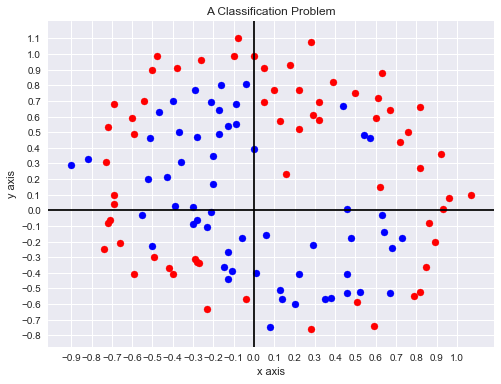

In [11]:
plt.figure(figsize=(8, 6))
sns.set(style='darkgrid')
plt.title('A Classification Problem')
plt.axvline(x=0.0, c='k')
plt.axhline(y=0.0, c='k')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.xticks(np.arange(-0.9, 1.1, step=0.1))
plt.yticks(np.arange(-0.8, 1.2, step=0.1))
plt.scatter(X_pass[:,0], X_pass[:,1], color='b') 
plt.scatter(X_fail[:,0], X_fail[:,1], color='r') 
plt.savefig('fake-data.pdf')

We want to split the data into a <em style="color:blue;">training set</em> and a <em style="color:blue;">test set</em>.
The <em style="color:blue;">training set</em> will be used to compute the parameters of our model, while the
<em style="color:blue;">testing set</em> is only used to check the *accuracy*.  SciKit-Learn has a predefined method
`sklearn.model_selection import train_test_split` that can be used to randomly split data into a training set and a test set.

In [13]:
from sklearn.model_selection import train_test_split

We will split the data at a ratio of $4:1$, i.e. $80\%$ of the data will be used for training, while the remaining $20\%$ is used to test the accuracy.

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In order to build a <em style="color:blue;">logistic regression</em> classifier, we import the module `linear_model` from SciKit-Learn.

In [15]:
import sklearn.linear_model as lm

The function $\texttt{logistic_regression}(\texttt{X_train}, \texttt{Y_train}, \texttt{X_test}, \texttt{Y_test})$ takes a feature matrix $\texttt{X_train}$ and a corresponding vector $\texttt{Y_train}$ and computes a logistic regression model $M$ that best fits these data.  Then, the accuracy of the model is computed using the test data $\texttt{X_test}$ and $\texttt{Y_test}$.

In [16]:
def logistic_regression(X_train, Y_train, X_test, Y_test, reg=10000):
    model       = lm.LogisticRegression(C=reg, tol=1e-6, solver='newton-cg')
    M           = model.fit(X_train, Y_train)
    train_score = M.score(X_train, Y_train)
    yPredict    = M.predict(X_test)
    accuracy    = np.sum(yPredict == Y_test) / len(Y_test)
    return M, train_score, accuracy

We use this function to build a model for our data.  Initially, we will take all the available data to create the model.

In [17]:
M, score, accuracy = logistic_regression(X, Y, X, Y)
score, accuracy

(0.6115702479338843, 0.6115702479338843)

Given that there are only two classes, the accuracy of our first model is quite poor.  
Let us extract the coefficients so we can plot the <em style="color:blue;">decision boundary</em>.

In [18]:
ϑ0     = M.intercept_
ϑ1, ϑ2 = M.coef_[0]

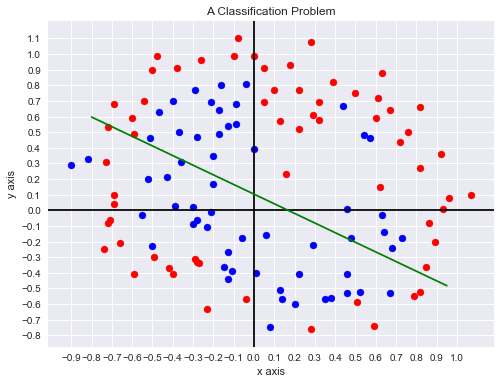

In [20]:
plt.figure(figsize=(8, 6))
sns.set(style='darkgrid')
plt.title('A Classification Problem')
plt.axvline(x=0.0, c='k')
plt.axhline(y=0.0, c='k')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.xticks(np.arange(-0.9, 1.1, step=0.1))
plt.yticks(np.arange(-0.8, 1.2, step=0.1))
plt.scatter(X_pass[:,0], X_pass[:,1], color='b') 
plt.scatter(X_fail[:,0], X_fail[:,1], color='r') 
H = np.arange(-0.8, 1.0, 0.05)
P = -(ϑ0 + ϑ1 * H)/ϑ2
plt.plot(H, P, color='green')
plt.savefig('fake-data-line.pdf')

Clearly, pure <em style="color:blue;">logistic regression</em> is not working for this example.  The reason is, that a linear decision boundary is not 
able to separate the positive examples from the negative examples.  Let us add <em style="color:blue;">polynomial features</em>.  This enables us to create 
more complex decision boundaries.

The function $\texttt{extend}(X)$ takes a feature matrix $X$ that is supposed to contain two features $x$ and $y$.  It creates the new features $x^2$, $y^2$ and $x\cdot y$ and returns a new feature matrix that also contains these additional features.

In [21]:
def extend(X):
    n  = len(X)
    fx = np.reshape(X[:,0], (n, 1))
    fy = np.reshape(X[:,1], (n, 1))
    return np.hstack([fx, fy, fx*fx, fy*fy, fx*fy])

In [22]:
X_train_quadratic = extend(X_train)
X_test_quadratic  = extend(X_test)

In [23]:
M, score, accuracy = logistic_regression(X_train_quadratic, Y_train, X_test_quadratic, Y_test)
score, accuracy

(0.84375, 0.76)

This seems to work better.  Let us compute the decision boundary and plot it.

In [24]:
ϑ0                 = M.intercept_
ϑ1, ϑ2, ϑ3, ϑ4, ϑ5 = M.coef_[0]

The decision boundary is now given by the following equation:
$$ \vartheta_0 + \vartheta_1 \cdot x + \vartheta_2 \cdot y + \vartheta_3 \cdot x^2 + \vartheta_4 \cdot y^2 + \vartheta_5 \cdot x \cdot y = 0$$
This is the equation of an ellipse.  Let us plot the <em style="color:blue;">decision boundary</em> with the data.

In [25]:
a    = np.arange(-1.0, 1.0, 0.005)
b    = np.arange(-1.0, 1.0, 0.005)
A, B = np.meshgrid(a,b)
Z    = ϑ0 + ϑ1 * A + ϑ2 * B + ϑ3 * A * A + ϑ4 * B * B + ϑ5 * A * B 

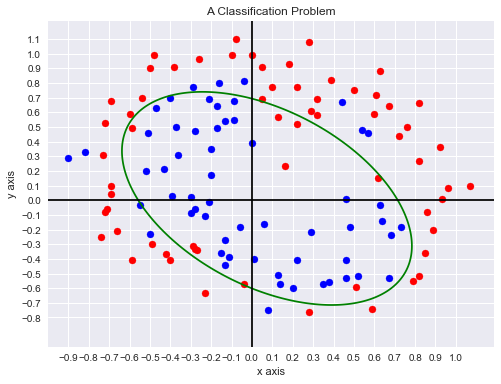

In [27]:
plt.figure(figsize=(8, 6))
sns.set(style='darkgrid')
plt.title('A Classification Problem')
plt.axvline(x=0.0, c='k')
plt.axhline(y=0.0, c='k')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.xticks(np.arange(-0.9, 1.1, step=0.1))
plt.yticks(np.arange(-0.8, 1.2, step=0.1))
plt.scatter(X_pass[:,0], X_pass[:,1], color='b') 
plt.scatter(X_fail[:,0], X_fail[:,1], color='r') 
CS = plt.contour(A, B, Z, 0, colors='green')
plt.savefig('fake-data-ellipse.pdf')

Let us try to add <em style="color:blue;">quartic features</em> next.  These are features like $x^4$, $x^2\cdot y^2$, etc.
Luckily, SciKit-Learn has function that can automize this process.

In [28]:
from sklearn.preprocessing import PolynomialFeatures

In [31]:
quartic = PolynomialFeatures(4, include_bias=False)
X_train_quartic = quartic.fit_transform(X_train)
X_test_quartic  = quartic.fit_transform(X_test)
print(quartic.get_feature_names(['x', 'y']))

['x', 'y', 'x^2', 'x y', 'y^2', 'x^3', 'x^2 y', 'x y^2', 'y^3', 'x^4', 'x^3 y', 'x^2 y^2', 'x y^3', 'y^4']


Let us fit the quartic model.

In [32]:
M, score, accuracy = logistic_regression(X_train_quartic, Y_train, X_test_quartic, Y_test)
score, accuracy

(0.8854166666666666, 0.76)

The accuracy on the training set has increased, but we observe that the accuracy on the training set is actually not improving. Again, we proceed to plot the decision boundary.

In [33]:
ϑ0 = M.intercept_
ϑ1, ϑ2, ϑ3, ϑ4, ϑ5, ϑ6, ϑ7, ϑ8, ϑ9, ϑ10, ϑ11, ϑ12, ϑ13, ϑ14 = M.coef_[0]

Plotting the decision boundary starts to get tedious.

In [34]:
a    = np.arange(-1.0, 1.0, 0.005)
b    = np.arange(-1.0, 1.0, 0.005)
A, B = np.meshgrid(a,b)
Z    = ϑ0 + ϑ1 * A + ϑ2 * B + \
       ϑ3 * A**2 + ϑ4 * A * B + ϑ5 * B**2 + \
       ϑ6 * A**3 + ϑ7 * A**2 * B + ϑ8 * A * B**2 + ϑ9 * B**3 + \
       ϑ10 * A**4 + ϑ11 * A**3 * B + ϑ12 * A**2 * B**2 + ϑ13 * A * B**3 + ϑ14 * B**4 

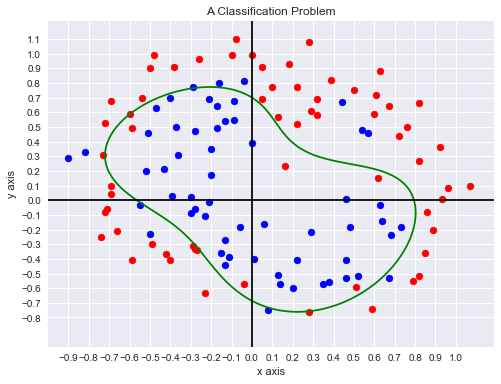

In [36]:
plt.figure(figsize=(8, 6))
sns.set(style='darkgrid')
plt.title('A Classification Problem')
plt.axvline(x=0.0, c='k')
plt.axhline(y=0.0, c='k')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.xticks(np.arange(-0.9, 1.1, step=0.1))
plt.yticks(np.arange(-0.8, 1.2, step=0.1))
plt.scatter(X_pass[:,0], X_pass[:,1], color='b') 
plt.scatter(X_fail[:,0], X_fail[:,1], color='r') 
CS = plt.contour(A, B, Z, 0, colors='green')
plt.savefig('fake-data-quartic.pdf')

The decision boundary looks strange.  Lets get bold and try to add features of a higher power.  
However, in order to understand what is happening, we will only plot the training data.

In [37]:
X_pass_train = X_train[Y_train == 1.0]
X_fail_train = X_train[Y_train == 0.0]

In order to automatize the process, we define some auxilliary functions.

$\texttt{polynomial}(n)$ creates a polynomial in the variables `A` and `B` that contains all terms of the form $\Theta[k] \cdot A^i \cdot B^j$ where $i+j \leq n$.

In [38]:
def polynomial(n):
    sum = 'Θ[0]' 
    cnt = 0
    for k in range(1, n+1):
        for i in range(0, k+1):
            cnt += 1
            sum += f' + Θ[{cnt}] * A**{k-i} * B**{i}'
    print('number of features:', cnt)
    return sum

Let's check this out for $n=4$.

In [39]:
polynomial(4)

number of features: 14


'Θ[0] + Θ[1] * A**1 * B**0 + Θ[2] * A**0 * B**1 + Θ[3] * A**2 * B**0 + Θ[4] * A**1 * B**1 + Θ[5] * A**0 * B**2 + Θ[6] * A**3 * B**0 + Θ[7] * A**2 * B**1 + Θ[8] * A**1 * B**2 + Θ[9] * A**0 * B**3 + Θ[10] * A**4 * B**0 + Θ[11] * A**3 * B**1 + Θ[12] * A**2 * B**2 + Θ[13] * A**1 * B**3 + Θ[14] * A**0 * B**4'

The function $\texttt{polynomial_grid}(n, M)$ takes a number $n$ and a model $M$.  It returns a meshgrid that can be used to plot the decision boundary of the model.

In [40]:
def polynomial_grid(n, M):
    Θ    = [M.intercept_] + list(M.coef_[0])
    a    = np.arange(-1.0, 1.0, 0.005)
    b    = np.arange(-1.0, 1.0, 0.005)
    A, B = np.meshgrid(a,b)
    return eval(polynomial(n))

The function $\texttt{plot_nth_degree_boundary}(n)$ creates a polynomial logistic regression model of degree $n$.  It plots both the training data and the decision boundary.

In [51]:
def plot_nth_degree_boundary(n, C=10000):
    poly         = PolynomialFeatures(n, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly  = poly.fit_transform(X_test)
    M, score, accuracy = logistic_regression(X_train_poly, Y_train, X_test_poly, Y_test, C)
    print('The accuracy on the training set is:', score)
    print('The accuracy on the test     set is:', accuracy)
    Z = polynomial_grid(n, M)
    plt.figure(figsize=(8, 6))
    sns.set(style='darkgrid')
    plt.title('A Classification Problem')
    plt.axvline(x=0.0, c='k')
    plt.axhline(y=0.0, c='k')
    plt.xlabel('x axis')
    plt.ylabel('y axis')
    plt.xticks(np.arange(-0.9, 1.11, step=0.1))
    plt.yticks(np.arange(-0.8, 1.21, step=0.1))
    plt.scatter(X_pass_train[:,0], X_pass_train[:,1], color='b') 
    plt.scatter(X_fail_train[:,0], X_fail_train[:,1], color='r') 
    CS = plt.contour(A, B, Z, 0, colors='green')
    plt.savefig('fake-data-' + str(n) + '.pdf')

Let us test this for the polynomial logistic regression model of degree $4$.

The accuracy on the training set is: 0.8854166666666666
The accuracy on the test     set is: 0.76
number of features: 14


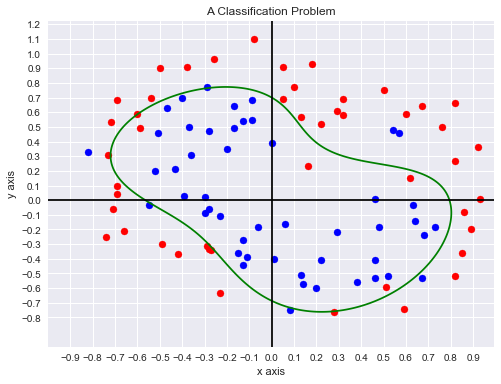

In [47]:
plot_nth_degree_boundary(4)

This seems to be the same shape that we have seen earlier.  It looks like the function $\texttt{plot_nth_degree_boundary}(n)$ is working.  Lets try higher degree polynomials.

The accuracy on the training set is: 0.9791666666666666
The accuracy on the test     set is: 0.8
number of features: 20


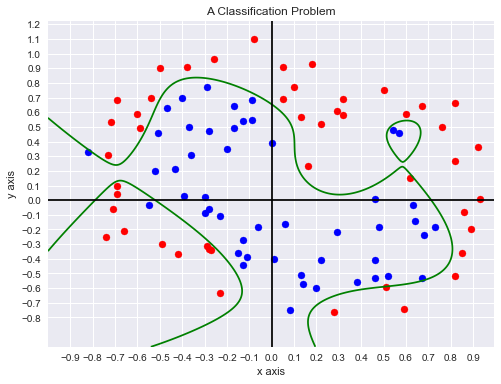

In [48]:
plot_nth_degree_boundary(5)

The score on the training set has improved.  What happens if we try still higher degrees?

The accuracy on the training set is: 0.9895833333333334
The accuracy on the test     set is: 0.84
number of features: 27


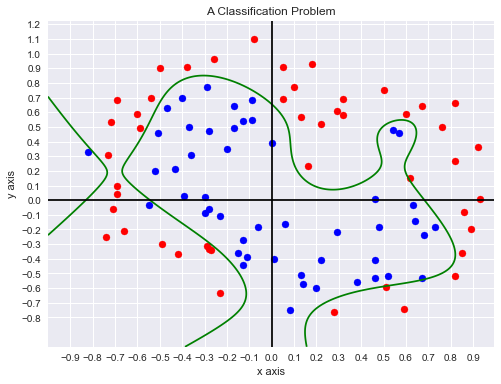

In [49]:
plot_nth_degree_boundary(6)

We captured one more of the training examples.  Lets get bold, we want a $100\%$ training accuracy.

The accuracy on the training set is: 1.0
The accuracy on the test     set is: 0.8
number of features: 119


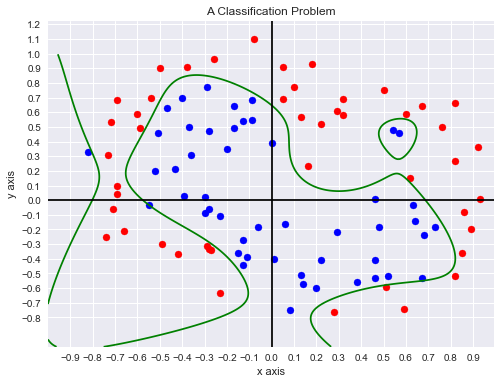

In [52]:
plot_nth_degree_boundary(14)

The model is getting more complicated, but it is not getting better, as the accuracy on the test set has not improved.

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
X_pass_train = X_train[Y_train == 1.0]
X_fail_train = X_train[Y_train == 0.0]

Let us check whether regularization can help.  Below, the regularization parameter prevents the decision boundary from becomming to wiggly and thus the accuracy on the test set can increase.

The accuracy on the training set is: 0.8958333333333334
The accuracy on the test     set is: 0.88
number of features: 119


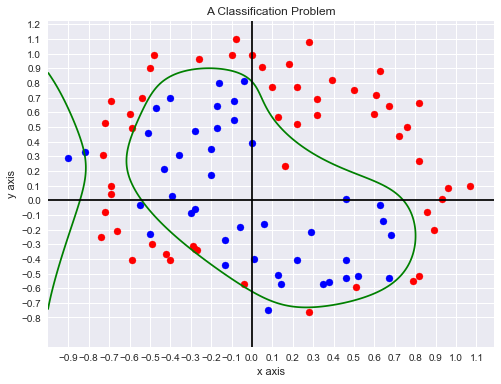

In [55]:
plot_nth_degree_boundary(14, 100.0)